In [1]:
import pandas as pd
import pyodbc
import numpy as np
import sqlalchemy as sq
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [2]:
### Connect to Data Fundation
engine = sq.create_engine("*****CHANGE TO YOUR DB CONNECTION INFO******")

sql = """
    select bar_code, 'fail' as event, piday_to_fail as time_to_event from failed_barcd
union
    select bar_code, 'censor' as event, operation_days as time_to_event from passed_barcd
"""

### read TIME_TO_EVENT data
df = pd.read_sql(sql, engine)

In [45]:
df.head()
df.tail()
pd.concat([df.iloc[:,1:].head(3),  df.iloc[:, 1:].tail(10)])

,event,time_to_event
0,censor,4303
1,censor,4300
2,censor,5015
29853,censor,3386
29854,fail,18
29855,censor,2433
29856,censor,1168
29857,censor,4611
29858,censor,4645
29859,censor,4645


In [4]:
df.event.value_counts()

censor    28529
fail       1334
Name: event, dtype: int64

## lifelines API

## Kaplan-Meier Estimation

In [5]:
from lifelines import KaplanMeierFitter

durations = df['time_to_event'].apply(lambda x: 0.5 if x==0 else x) # workarrounds for DOA
event_observed = df['event'].apply(lambda x: 1 if x=='fail' else 0)

km = KaplanMeierFitter()

km.fit(durations, event_observed, label='KM')
km

<lifelines.KaplanMeierFitter:"KM", fitted with 29863 total observations, 28529 right-censored observations>

In [9]:
km.event_table.tail(10)

,removed,observed,censored,entrance,at_risk,pdf,cdf
event_at,,,,,,,
5114.0,2,0,2,0,13,0.0,0.04851
5115.0,2,0,2,0,11,0.0,0.04851
5116.0,1,0,1,0,9,0.0,0.04851
5118.0,1,0,1,0,8,0.0,0.04851
5120.0,2,0,2,0,7,0.0,0.04851
5122.0,1,0,1,0,5,0.0,0.04851
5124.0,1,0,1,0,4,0.0,0.04851
5130.0,1,0,1,0,3,0.0,0.04851
5133.0,1,0,1,0,2,0.0,0.04851


In [8]:
event = km.event_table

event['pdf'] = event.observed / event.at_risk.shift(periods=1, fill_value=0)
event['cdf'] = event['pdf'].cumsum()
event.fillna(0, inplace=True)
event.tail(10)

,removed,observed,censored,entrance,at_risk,pdf,cdf
event_at,,,,,,,
5114.0,2,0,2,0,13,0.0,0.04851
5115.0,2,0,2,0,11,0.0,0.04851
5116.0,1,0,1,0,9,0.0,0.04851
5118.0,1,0,1,0,8,0.0,0.04851
5120.0,2,0,2,0,7,0.0,0.04851
5122.0,1,0,1,0,5,0.0,0.04851
5124.0,1,0,1,0,4,0.0,0.04851
5130.0,1,0,1,0,3,0.0,0.04851
5133.0,1,0,1,0,2,0.0,0.04851


In [10]:
km.cumulative_density_.head(10) # CDF

,KM
timeline,
0.0,0.000000
0.5,0.004554
1.0,0.005157
2.0,0.005458
3.0,0.005693
4.0,0.005860
5.0,0.006128
6.0,0.006563
7.0,0.006764


In [11]:
km.survival_function_.head(10) # complement of CDF

,KM
timeline,
0.0,1.000000
0.5,0.995446
1.0,0.994843
2.0,0.994542
3.0,0.994307
4.0,0.994140
5.0,0.993872
6.0,0.993437
7.0,0.993236


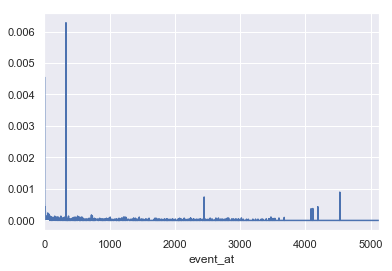

In [12]:
event.pdf.plot()

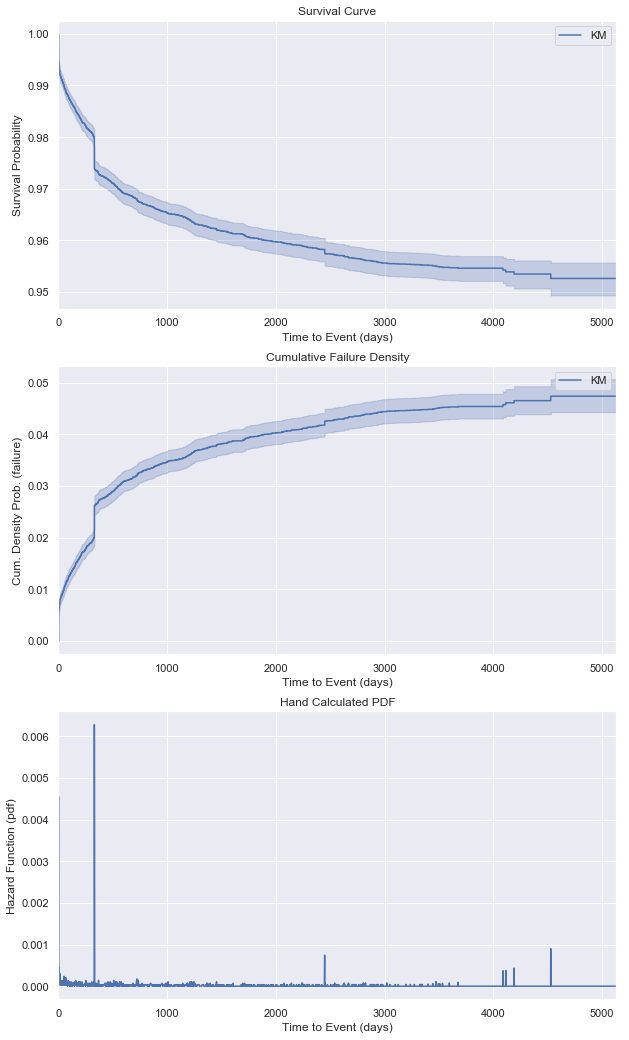

In [13]:
plt.figure(figsize=(10, 18))
plt.subplot(3, 1, 1)
km.plot_survival_function()
plt.title('Survival Curve')
plt.xlabel('Time to Event (days)')
plt.ylabel('Survival Probability')

plt.subplot(3, 1, 2)
km.plot_cumulative_density()
plt.title('Cumulative Failure Density')
plt.xlabel('Time to Event (days)')
plt.ylabel('Cum. Density Prob. (failure)')


plt.subplot(3, 1, 3)
event.pdf.plot()
plt.title('Hand Calculated PDF')
plt.xlabel('Time to Event (days)')
plt.ylabel('Hazard Function (pdf)')

plt.show()

In [14]:
from lifelines.utils import median_survival_times

median_ = km.median_survival_time_
median_confidence_interval_ = median_survival_times(km.confidence_interval_)

print('Median survival time is {}'.format(median_))
print('With 95% confidence interval: ')
print(median_confidence_interval_)

Median survival time is inf
With 95% confidence interval: 
     KM_lower_0.95  KM_upper_0.95
0.5            inf            inf


In [15]:
from lifelines.utils import qth_survival_time
SLAs = [0.50, 0.75, 0.95, 0.96, 0.97, 0.98, 0.99]
print('{:<30}{:<40}'.format('Survival Rate (SR)', 'Time To SR'))
for sla in SLAs:
    print('{:<30}{:<40}'.format(sla, qth_survival_time(sla, km)))
#qth_survival_time(0.96, km)

Survival Rate (SR)            Time To SR                              
0.5                           inf                                     
0.75                          inf                                     
0.95                          inf                                     
0.96                          1895.0                                  
0.97                          547.0                                   
0.98                          329.0                                   
0.99                          50.0                                    


## Lifelines WeibullFitter

In [16]:
from lifelines import * 

wbf = WeibullFitter().fit(durations[1:], event_observed[1:], label='WeibullFitter')

In [17]:
wbf.summary

,coef,se(coef),coef lower 95%,coef upper 95%,z,p,-log2(p)
lambda_,900.406239,55.129884,792.353651,1008.458827,16.314314,7.807851e-60,196.35076
rho_,0.033382,0.001746,0.029960,0.036805,-553.480830,0.000000e+00,inf


The fitted *Weibull distribution* shows that **shape rho_ < 1** (0.033) indicates **infant mortality** and **scale lambda_ >> 1** (~900) displays flatness.

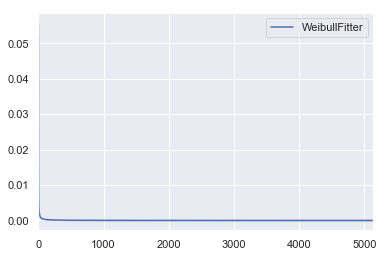

In [18]:
wbf.plot_hazard()

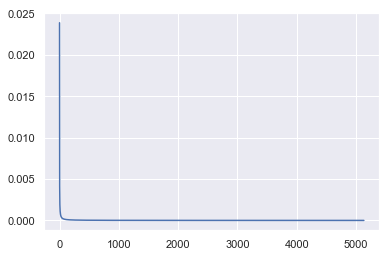

In [19]:
from scipy.stats import weibull_min

plt.plot(wbf.timeline, weibull_min.pdf(wbf.timeline, wbf.rho_, scale=wbf.lambda_))


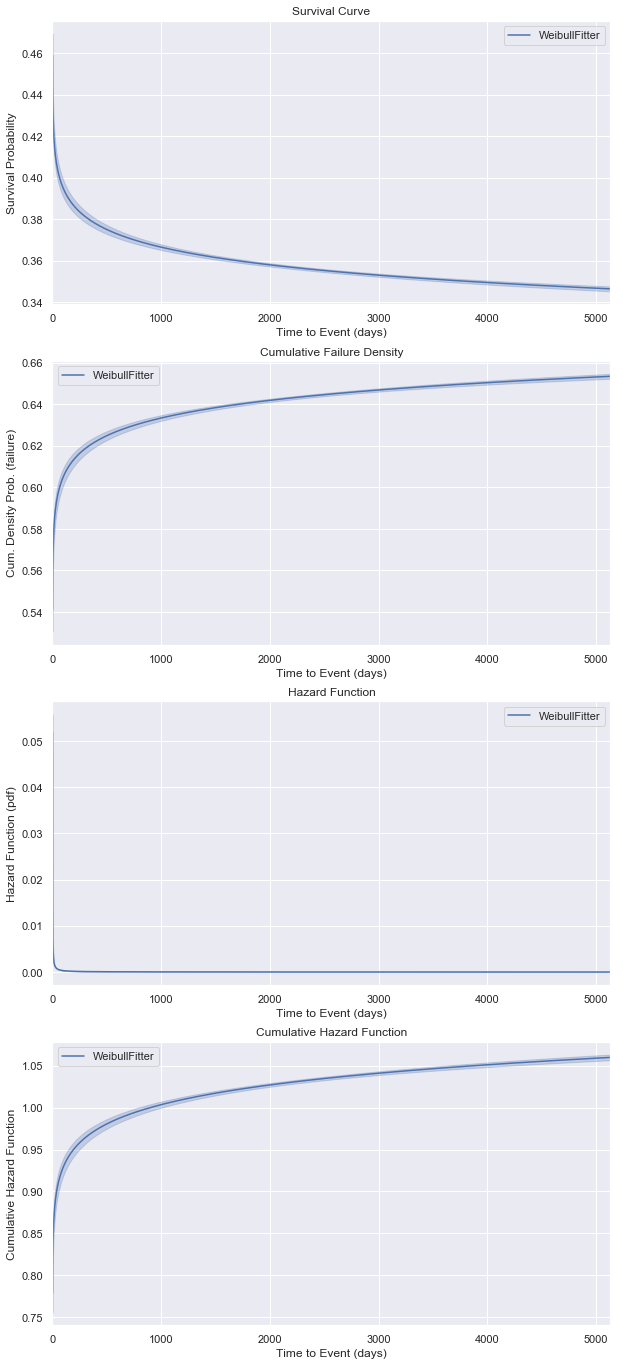

In [20]:
plt.figure(figsize=(10, 24))
plt.subplot(4, 1, 1)
wbf.plot_survival_function()
plt.title('Survival Curve')
plt.xlabel('Time to Event (days)')
plt.ylabel('Survival Probability')

plt.subplot(4, 1, 2)
wbf.plot_cumulative_density()
plt.title('Cumulative Failure Density')
plt.xlabel('Time to Event (days)')
plt.ylabel('Cum. Density Prob. (failure)')


plt.subplot(4, 1, 3)
wbf.plot_hazard()
plt.title('Hazard Function')
plt.xlabel('Time to Event (days)')
plt.ylabel('Hazard Function (pdf)')

plt.subplot(4, 1, 4)
wbf.plot_cumulative_hazard()
plt.title('Cumulative Hazard Function')
plt.xlabel('Time to Event (days)')
plt.ylabel('Cumulative Hazard Function')

plt.show()

 In fact, weibull distribution fits our data **poortly**, and we can observe that by looking at **qqplot** as below. *None falls on the diagonal line*. Instead, **Log Normal** seems to be a better fit. 

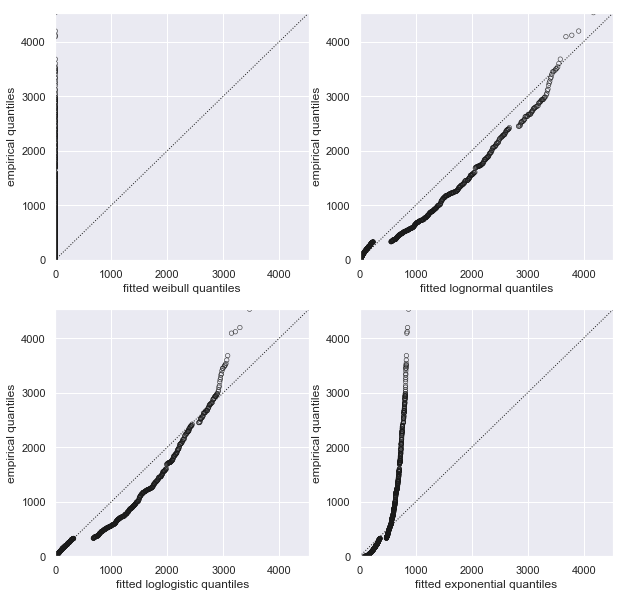

In [21]:
from lifelines.plotting import qq_plot

durations = df['time_to_event'].apply(lambda x: 0.5 if x==0 else x)
event_observed = df['event'].apply(lambda x: 1 if x=='fail' else 0)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.reshape(4, )

for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(durations, event_observed)
    qq_plot(model, ax=axes[i])

## Log Normal

In [22]:
lnf = LogNormalFitter().fit(durations, event_observed)
lnf.summary

,coef,se(coef),coef lower 95%,coef upper 95%,z,p,-log2(p)
mu_,20.798634,0.337764,20.136629,21.460640,58.616715,0.000000e+00,inf
sigma_,7.459443,0.182015,7.102701,7.816186,35.488575,7.375924e-276,913.96933


In [23]:
np.exp(lnf.mu_)

1078281505.1617172

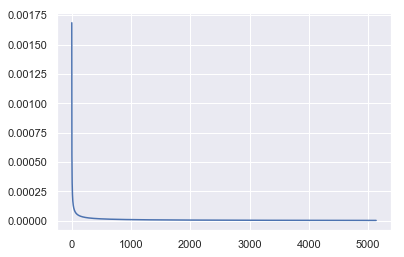

In [24]:
from scipy.stats import lognorm

plt.plot(lnf.timeline, lognorm.pdf(lnf.timeline, lnf.sigma_, 0, np.exp(lnf.mu_)))

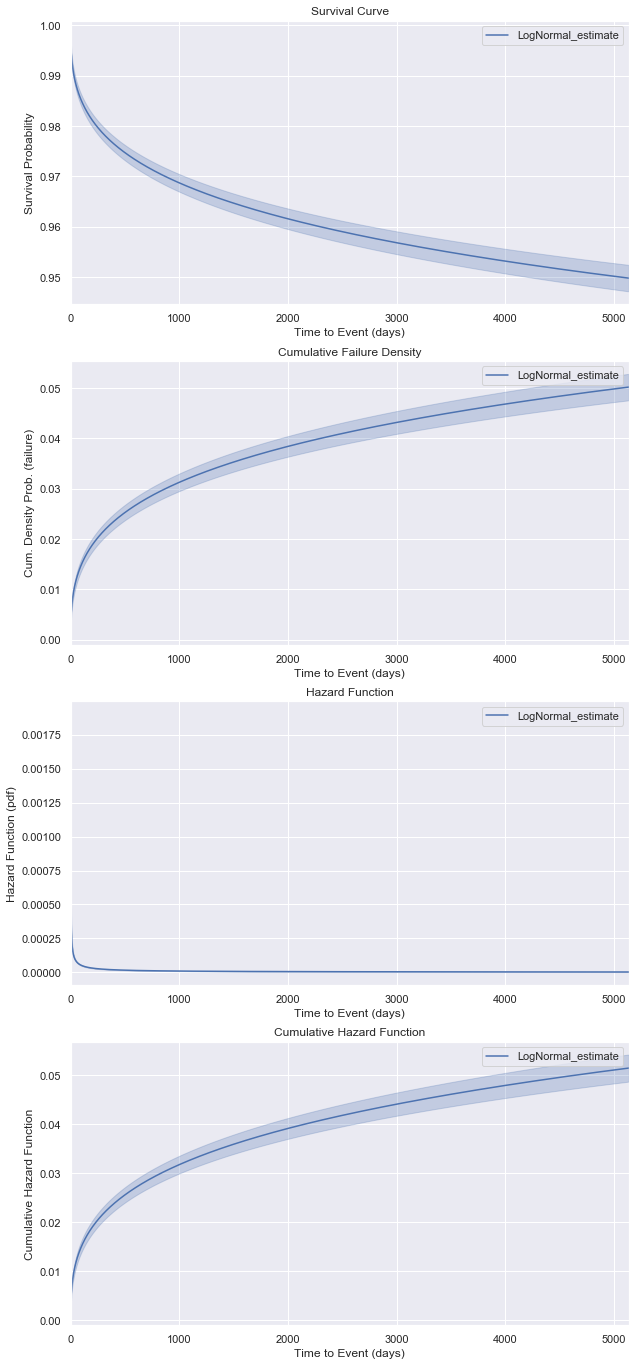

In [25]:
plt.figure(figsize=(10, 24))
plt.subplot(4, 1, 1)
lnf.plot_survival_function()
plt.title('Survival Curve')
plt.xlabel('Time to Event (days)')
plt.ylabel('Survival Probability')

plt.subplot(4, 1, 2)
lnf.plot_cumulative_density()
plt.title('Cumulative Failure Density')
plt.xlabel('Time to Event (days)')
plt.ylabel('Cum. Density Prob. (failure)')


plt.subplot(4, 1, 3)
lnf.plot_hazard()
plt.title('Hazard Function')
plt.xlabel('Time to Event (days)')
plt.ylabel('Hazard Function (pdf)')

plt.subplot(4, 1, 4)
lnf.plot_cumulative_hazard()
plt.title('Cumulative Hazard Function')
plt.xlabel('Time to Event (days)')
plt.ylabel('Cumulative Hazard Function')

plt.show()

In [26]:
median_ = lnf.median_survival_time_
median_confidence_interval_ = median_survival_times(lnf.confidence_interval_)

print('Median survival time is {}'.format(median_))
print('With 95% confidence interval: ')
print(median_confidence_interval_)

Median survival time is 1078281505.1617172
With 95% confidence interval: 
     LogNormal_estimate_lower_0.95  LogNormal_estimate_upper_0.95
0.5                            0.5                            0.5


In [27]:
from lifelines.utils import qth_survival_time
SLAs = [0.50, 0.75, 0.95, 0.96, 0.97, 0.98, 0.99]
print('{:<30}{:<40}{:<40}{:<40}'.format('Survival Rate (SR)', 'Time To SR(days)', 'Weeks', 'Months'))
for sla in SLAs:
    surv_time = qth_survival_time(sla, lnf)
    print('{:<30}{:<40}{:<40}{:<40}'.format(sla, surv_time, int(surv_time/7), int(surv_time/30)))
#qth_survival_time(0.96, km)

Survival Rate (SR)            Time To SR(days)                        Weeks                                   Months                                  
0.5                           1078281505.1617172                      154040215                               35942716                                
0.75                          7041391.815139502                       1005913                                 234713                                  
0.95                          5059.091276005309                       722                                     168                                     
0.96                          2297.3028641678757                      328                                     76                                      
0.97                          870.4072977925551                       124                                     29                                      
0.98                          239.5616990927723                       34                      

## Annualized Failure Rate (AFR)

In [28]:
# ultimate failure rate
fr = lnf.hazard_.iloc[-1, 0]
MTBF_days = 1/fr
MTBF_mons = round(MTBF_days / 30, 1)
MTBF_yrs = round(MTBF_days / 365, 1)

In [29]:
fr, MTBF_days, MTBF_mons, MTBF_yrs

(2.8446096231169106e-06, 351542.08573065104, 11718.1, 963.1)

In [30]:
AFR = fr*365
AFR # failures per year

0.0010382825124376723

In [36]:
num_active_parts = 200000
#df.loc[df['event']=='censor', 'bar_code'].count()


num_active_parts, num_active_parts * AFR # ~30 failures per year ## use Lead Time instead

(200000, 207.65650248753445)

Text(0.5, 1.0, 'Number of failures occur in a year in Prob.')

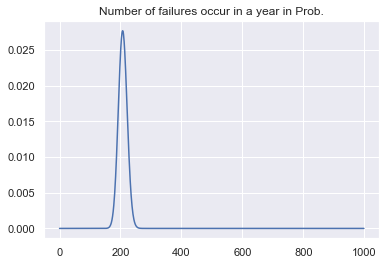

In [37]:
from scipy.stats import poisson

mu = num_active_parts * AFR
x = np.arange(0, 1000, 1)
plt.plot(x, poisson.pmf(x, mu))
plt.title('Number of failures occur in a year in Prob.')

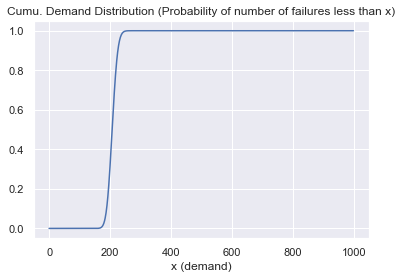

In [38]:
plt.plot(x, poisson.cdf(x, mu))
plt.title('Cumu. Demand Distribution (Probability of number of failures less than x)')
plt.xlabel('x (demand)')
plt.show()

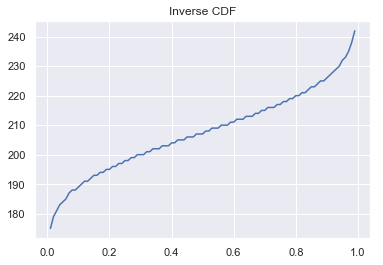

In [39]:
i = np.arange(0.01, 1, 0.01)
plt.plot(i, poisson.isf(1-i, mu)) # cdf modified from isf, for some reason, there is no inverse CDF, but inverse survival function
plt.title('Inverse CDF')
plt.show()

In [40]:
SLAs = [0.50, 0.75, 0.95, 0.96, 0.97, 0.98, 0.99, 0.9999999, 1]
print('{:<30}{:<40}'.format('Reliability', '# Spares'))
for sla in SLAs:
    print('{:<30}{:<40}'.format(sla, poisson.isf(1-sla, mu)))

Reliability                   # Spares                                
0.5                           207.0                                   
0.75                          217.0                                   
0.95                          232.0                                   
0.96                          233.0                                   
0.97                          235.0                                   
0.98                          238.0                                   
0.99                          242.0                                   
0.9999999                     287.0                                   
1                             inf                                     


This simplified model -- *constant failure rate = 2.844e-6 per day / AFR = 207 per year out of 200K parts* -- fitted in *poisson distribution* recommends **242 spares in a year to achieve 99% reliability**. 